In [1]:
import pandas as pd
import numpy as np
import time
import joblib

# Training Test
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

# Algorithms
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier

C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load and Prepro

In [2]:
# Load data
data = pd.read_csv('data/heart.csv')

# remove duplicates
data = data.drop_duplicates()
print(data.shape)

# Train test sets
X = data.drop(columns='output')
y = data['output']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_train.shape)

# Preprocessor
num_var = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
# cat_var = [col for col in X_train.columns if col not in num_var]

num_prep = ColumnTransformer([('num_prepo', StandardScaler(), num_var)],
                             remainder='passthrough')

(302, 14)
(241, 13) (241,) (61, 13) (241,)


In [3]:
tree_classifiers = {
  "Extra Trees": ExtraTreesClassifier(random_state=0),
  "Random Forest":RandomForestClassifier(random_state=0),
  "AdaBoost": AdaBoostClassifier(random_state=0),
  "Skl GBM": GradientBoostingClassifier(random_state=0),
  "Skl HistGBM": HistGradientBoostingClassifier(random_state=0),
  "XGBoost": XGBClassifier(),
  "LightGBM": LGBMClassifier(random_state=0),
  "CatBoost": CatBoostClassifier(random_state=0)}

tree_classifiers_pipe = {name: make_pipeline(num_prep, model) for name, model in tree_classifiers.items()}

# Benchmark accuracy

In [4]:
results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Time': []})

for model_name, model in tree_classifiers_pipe.items():
    start_time = time.time()
    
    # Training
    model.fit(X_train, y_train)
    
    # Prediction
    pred = model.predict(X_test)

    total_time = time.time() - start_time # Time taken to fit and predict

    model_results = pd.DataFrame({"Model":    [model_name],
                              "Accuracy": [accuracy_score(y_test, pred)*100],
                              "Time":     [total_time]})
    results = pd.concat([results, model_results])
    
    

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord

C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:31] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.005611
0:	learn: 0.6889865	total: 139ms	remaining: 2m 18s
1:	learn: 0.6848531	total: 142ms	remaining: 1m 11s
2:	learn: 0.6809871	total: 149ms	remaining: 49.4s
3:	learn: 0.6763709	total: 153ms	remaining: 38s
4:	learn: 0.6724458	total: 155ms	remaining: 30.9s
5:	learn: 0.6680178	total: 158ms	remaining: 26.1s
6:	learn: 0.6639458	total: 162ms	remaining: 23s
7:	learn: 0.6593551	total: 166ms	remaining: 20.6s
8:	learn: 0.6556964	total: 168ms	remaining: 18.5s
9:	learn: 0.6532886	total: 169ms	remaining: 16.8s
10:	learn: 0.6508652	total: 172ms	remaining: 15.5s
11:	learn: 0.6470071	total: 174ms	remaining: 14.3s
12:	learn: 0.6428190	total: 177ms	remaining: 13.5s
13:	learn: 0.6392243	total: 17

,Model,Accuracy,Time
0,AdaBoost,91.803279,0.158527
1,Extra Trees,88.524590,0.363001
2,Random Forest,86.885246,0.277473
3,CatBoost,86.885246,3.865384
4,Skl GBM,81.967213,0.151052
5,XGBoost,81.967213,0.160562
6,LightGBM,80.327869,0.094161
7,Skl HistGBM,78.688525,0.433102


# Data augmentation

In [5]:
def data_enhancement(data):
    np.random.seed(0)
    gen_data = data.copy()
    sep_on = 'sex'
    divide_std_by = 10
    
    for value in data[sep_on].unique():
        sub_data =  gen_data[gen_data[sep_on] == value]

        age_std = sub_data['age'].std()
        
        trtbps_std = sub_data['trtbps'].std()
       
        chol_std = sub_data['chol'].std()
      
        thalachh_std = sub_data['thalachh'].std()
    
        oldpeak_std = sub_data['oldpeak'].std()
     
        
        for i in gen_data[gen_data[sep_on] == value].index:
            if np.random.randint(2) == 1:
                gen_data.loc[i,'age'] += age_std/divide_std_by
            else:
                gen_data.loc[i,'age'] -= age_std/divide_std_by
                
            if np.random.randint(2) == 1:
                gen_data.loc[i,'trtbps'] += trtbps_std/divide_std_by
            else:
                gen_data.loc[i,'trtbps'] -= trtbps_std/divide_std_by
                
            if np.random.randint(2) == 1:
                gen_data.loc[i,'chol'] += chol_std/divide_std_by
            else:
                gen_data.loc[i,'chol'] -= chol_std/divide_std_by
                
            if np.random.randint(2) == 1:
                gen_data.loc[i,'thalachh'] += thalachh_std/divide_std_by
            else:
                gen_data.loc[i,'thalachh'] -= thalachh_std/divide_std_by

            if np.random.randint(2) == 1:
                gen_data.loc[i,'oldpeak'] += oldpeak_std/divide_std_by
            else:
                gen_data.loc[i,'oldpeak'] -= oldpeak_std/divide_std_by

    return gen_data




In [6]:
gen = data_enhancement(data)
np.random.seed(0)
extra_data = gen.sample(gen.shape[0] // 5)

X_train_aug = pd.concat([X_train, extra_data.drop(['output'], axis=1) ])
y_train_aug = pd.concat([y_train, extra_data['output'] ])

print(f'Augmented X_train by {((len(X_train_aug) - len(X_train)) / len(X_train)) * 100 }%')

Augmented X_train by 24.896265560165975%


In [7]:
X_train.shape, X_train_aug.shape

((241, 13), (301, 13))

In [8]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [9]:
gen.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,62.116316,1,3,146.669152,237.264976,1,0,147.586895,0,2.417490,0,0,1,1
1,37.883684,1,2,131.669152,254.264976,0,1,189.413105,0,3.617490,0,0,2,1
2,41.940940,0,1,128.068888,210.508895,0,0,169.995203,0,1.511984,2,0,2,1
3,56.883684,1,1,118.330848,231.735024,0,1,180.413105,0,0.682510,2,0,2,1
4,56.059060,0,0,121.931112,360.508895,0,1,160.995203,1,0.711984,2,0,2,1


In [10]:
tree_classifiers_pipe_aug = {name: make_pipeline(num_prep, model) for name, model in tree_classifiers.items()}
results_aug = pd.DataFrame({'Model': [], 'Accuracy': [], 'Time': []})

for model_name, model in tree_classifiers_pipe_aug.items():
    start_time = time.time()
    
    # Training
    model.fit(X_train_aug, y_train_aug)
    
    # Prediction
    pred_aug = model.predict(X_test)

    total_time = time.time() - start_time # Time taken to fit and predict

    model_results_aug = pd.DataFrame({"Model":    [model_name],
                              "Accuracy": [accuracy_score(y_test, pred_aug)*100],
                              "Time":     [total_time]})


    results_aug = pd.concat([results_aug, model_results_aug])
    results_ord_aug = results_aug.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord_aug

C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:25:46] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.00617
0:	learn: 0.6879046	total: 4.92ms	remaining: 4.91s
1:	learn: 0.6828536	total: 7.45ms	remaining: 3.72s
2:	learn: 0.6783135	total: 9.51ms	remaining: 3.16s
3:	learn: 0.6728699	total: 11.7ms	remaining: 2.92s
4:	learn: 0.6680912	total: 14.2ms	remaining: 2.83s
5:	learn: 0.6634160	total: 19.1ms	remaining: 3.16s
6:	learn: 0.6602034	total: 21.9ms	remaining: 3.11s
7:	learn: 0.6553306	total: 24.2ms	remaining: 3s
8:	learn: 0.6499917	total: 28ms	remaining: 3.09s
9:	learn: 0.6463995	total: 39.2ms	remaining: 3.88s
10:	learn: 0.6415333	total: 44ms	remaining: 3.95s
11:	learn: 0.6368310	total: 47.7ms	remaining: 3.92s
12:	learn: 0.6326124	total: 52.2ms	remaining: 3.97s
13:	learn: 0.6288041	to

,Model,Accuracy,Time
0,Extra Trees,100.000000,0.525527
1,CatBoost,98.360656,4.116518
2,Random Forest,96.721311,0.639966
3,Skl HistGBM,96.721311,0.660996
4,XGBoost,96.721311,0.167007
5,LightGBM,96.721311,0.099526
6,Skl GBM,93.442623,0.194002
7,AdaBoost,91.803279,0.150020


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        34

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


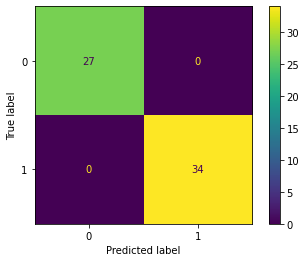

In [11]:

final_model = tree_classifiers_pipe_aug['Extra Trees']
final_model.fit(X_train_aug,y_train_aug)

pred_final = final_model.predict(X_test)
# print(classification_report(y_test, pred_final))
plot_confusion_matrix(final_model, X_test, y_test);

In [12]:
# Saving model
joblib.dump(final_model, 'model.joblib')

['model.joblib']

In [18]:
# example data for CLI
X_test.head(10).to_csv('device/test_data.csv')

In [19]:
y_test.head(10)

226    0
152    1
229    0
202    0
52     1
246    0
176    0
169    0
224    0
218    0
Name: output, dtype: int64

# Feature reduction


In [20]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
